<a href="https://colab.research.google.com/github/gmb408/OSSP-KBO-prediction/blob/main/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# 데이터 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [57]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [58]:
# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression

In [59]:
result = pd.read_csv("/content/statiz_Final.csv", index_col=0)
result=result.reset_index(drop=True)

In [60]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','타석','득점','안타','1타','2타','3타','홈런','루타','타점','볼넷','삼진'\
        ,'타율','출루','isoD','장타','isoP','OPS','wOBA','wRC+','WAR+']


In [61]:
# 누적 및 lag stat features 이름
stats_cum = [i + '_누적' for i in stats]
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [62]:
# X features와 y feature 정리
stats_position = ['2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS']
X_cols = stats + stats_cum + stats_lag1 + stats_lag2 +  stats_lag3  + stats_position +['나이'] +['연차']
y_cols = ['OPS_NEXT']

#예측에 사용되는 수치형 데이터 표준화
z_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_lag3  +['나이'] +['연차']

stand = pd.DataFrame(data=result,columns=z_cols)
scaler = StandardScaler()
scaler.fit(stand)
data_scaled = scaler.transform(stand)
result_scaled = pd.DataFrame(data_scaled,columns=z_cols)
result[z_cols] = result_scaled[z_cols]



In [63]:
df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['OPS_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환
df= df.reset_index(drop=True)

In [64]:
# 학습시킬 모델
model_dict = {'xgb':XGBRegressor(objective ='reg:squarederror',n_estimators=500, learning_rate=0.01 ,max_depth=3, random_state=99),
              'lgbm':LGBMRegressor(gamma= 0.5, learning_rate= 0.01, max_depth= 3, n_estimators= 1000, random_state= 99),
              'ridge':Ridge(alpha=10),
              'gbm' : GradientBoostingRegressor(learning_rate= 0.01, max_depth= 4, n_estimators= 500, random_state= 99)
              }

In [65]:
def get_stacking_base_datasets(model, train,test, n_folds):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True)

    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 배열 초기화 
    train_fold_pred = np.zeros((train.shape[0] ,1 ))
    test_pred = np.zeros((test.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(train)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 분할
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        #인덱스 기준으로 데이터를 분할 
        tra, val = train.iloc[train_index], train.iloc[valid_index]
        X_tr = tra[X_cols] 
        y_tr = tra[y_cols] 
        X_vl = val[X_cols]
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_vl).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(test[X_cols]).reshape(1,-1)
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred 최종 모델의 학습데이터 test_pred_mean 최종 모델의 학습 데이터
    return train_fold_pred , test_pred_mean

In [66]:
#학습용 데이터 ~2016 테스트데이터 2016~2021
train = df[df['시즌'] < 2016].reset_index(drop=True)
test = df[(df['시즌'] > 2015) & (2022 > df['시즌'])].reset_index(drop=True)

y_train = train[y_cols]
y_test = test[y_cols]

model = model_dict['lgbm']
model2 = model_dict['xgb']
model3 = model_dict['gbm']
model4 = model_dict['ridge']
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 

# CV스태킹 알고리즘 각 모델에 적용
xgb_train, xgb_test = get_stacking_base_datasets(model,train,test,7)
lgbm_train, lgbm_test = get_stacking_base_datasets(model2, train,test, 7)
gbm_train, gbm_test = get_stacking_base_datasets(model3,train,test,  7)  

# CV스태킹 알고리즘 결과로 메타 모델 학습/시험에 필요한 result_a result_b 만들기 
Stack_final_X_train = np.concatenate((xgb_train, lgbm_train, gbm_train), axis=1)
Stack_final_X_test = np.concatenate((xgb_test, lgbm_test, gbm_test), axis=1)

# 메타 모델 학습
model4.fit(Stack_final_X_train,y_train )
stack_final = model4.predict(Stack_final_X_test)

LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
GradientBoostingRegressor  model 시작 
	 폴드 세트:  0  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  1  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  2  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  3  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  4  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  5  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  6  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [67]:
#검증 지표
y_test = test[y_cols]

mse=mean_squared_error(y_test,  stack_final ,squared=False)
rmse =  np.sqrt(mse)
r2 =r2_score(y_test, stack_final)
print("test error : ", mse)
print("RMSE : ", rmse)
print("r2 : ", r2)
print("완료")


test error :  0.09181339449456011
RMSE :  0.3030072515544143
r2 :  0.40653602427025626
완료


,ID,이름,생일,팀,시즌,포지션,나이,G,타수,타석,...,연차,1B,2B,3B,C,CF,DH,LF,RF,SS
0,15,최형우,1983-12-16,삼,2016,LF,1.050155,1.572694,1.887838,2.031480,...,0.993962,0,0,0,0,0,0,1,0,0
1,18,김재환,1988-09-22,두,2017,LF,0.120660,1.795811,2.085669,2.154905,...,-0.534114,0,0,0,0,0,0,1,0,0
2,28,박건우,1990-09-08,두,2017,CF,-0.344087,1.312391,1.602963,1.517211,...,-0.534114,0,0,0,0,1,0,0,0,0
3,18,김재환,1988-09-22,두,2018,LF,0.353034,1.609880,1.951144,1.921769,...,-0.279435,0,0,0,0,0,0,1,0,0
4,15,최형우,1983-12-16,K,2017,LF,1.282529,1.721439,1.848272,2.106907,...,1.248642,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,430,김동엽,1990-07-24,삼,2019,DH,0.120660,-1.327827,-0.676043,-0.759290,...,-0.279435,0,0,0,0,0,1,0,0,0
629,1098,박계범,1996-01-11,삼,2020,SS,-1.041208,-0.584104,-0.921352,-1.006139,...,-0.788794,0,0,0,0,0,0,0,0,1
630,272,이성열,1984-07-13,한,2020,DH,1.747277,-0.621290,-0.422820,-0.505583,...,2.522039,0,0,0,0,0,1,0,0,0
631,793,김태진,1995-10-07,NK,2020,3B,-0.808835,-0.509731,-0.137944,-0.286162,...,-0.788794,0,0,1,0,0,0,0,0,0


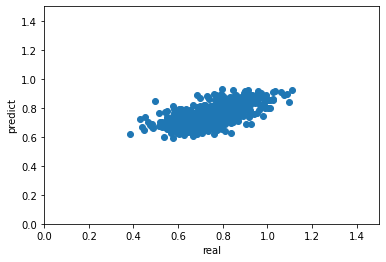

In [68]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, stack_final)
plt.xlabel("real")
plt.ylabel("predict")
plt.xlim(0,1.5)
plt.ylim(0,1.5)
test

In [75]:
result = pd.read_csv("/content/statiz_Final.csv", index_col=0)
sample = test
sample['y_hat'] = stack_final

sample = sample[sample['시즌']==2021]

new = ['이름','생일','y_hat']
new2 = ['이름','생일','팀','시즌','포지션','OPS']
sample = sample[new]

predict = result[result['시즌']==2022] # 2018년도 데이터 프레임
predict=predict[new2]

final = pd.merge(predict, sample, on=('이름','생일'), how='inner')
error = final['OPS'] - final['y_hat']
print("오차 ",np.mean(error))
final['오차'] = error
final = final.sort_values('y_hat',ascending =False )
final

오차  -0.029294095832794183


,이름,생일,팀,시즌,포지션,OPS,y_hat,오차
8,양의지,1987-06-05,N,2022,C,0.861,0.887279,-0.026279
44,구자욱,1993-02-12,삼,2022,RF,0.736,0.876994,-0.140994
2,나성범,1989-10-03,K,2022,RF,0.910,0.875981,0.034019
0,이정후,1998-08-20,키,2022,CF,0.996,0.860991,0.135009
12,한유섬,1989-08-09,S,2022,RF,0.851,0.855971,-0.004971
...,...,...,...,...,...,...,...,...
46,강한울,1991-09-12,삼,2022,3B,0.773,0.644842,0.128158
65,김민식,1989-06-28,KS,2022,C,0.618,0.643866,-0.025866
81,장운호,1994-02-20,한,2022,RF,0.627,0.641550,-0.014550
56,이지영,1986-02-27,키,2022,C,0.634,0.637297,-0.003297
